#### Objectives

- Provide a quick reference for the librosa features I want to use in my genre classifier 
- Each feature should have code samples for calculation and visualization or interpretation
- Features and function parameters need verbose descriptions (more than what's in the documentation)
- Pay attention to how long it takes each function to run and each plot to generate

In [21]:
import librosa
import os
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

In [22]:
song_dir = "/Users/cliffclive/Desktop/Workbench/sort these"
song_file = "Badoxa - Me Toca.MP3"
filepath = os.path.join(song_dir, song_file)

In [23]:
y, sr = librosa.load(filepath, offset=30, duration=16)

# Spectral Features

## Mel Spectrogram

In [24]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)

In [25]:
S_dB = librosa.power_to_db(S, ref=np.max)

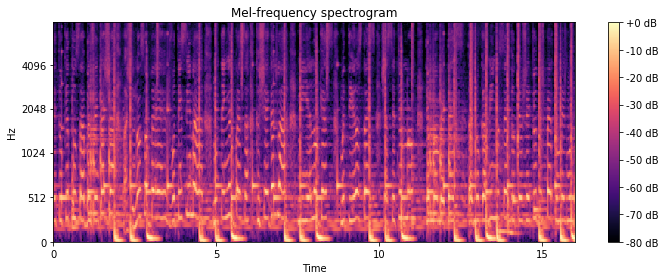

In [26]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

## MFCCs

[Documentation](https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html)



In [27]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

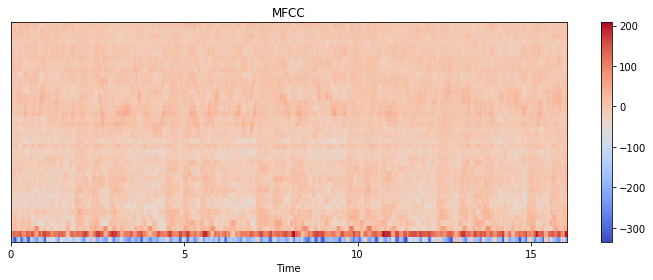

In [28]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

# Rhythm Features

## Tempogram

`hop_length` : The number of samples between successive frames, e.g., the columns of a spectrogram. This is denoted as a positive integer. 

[`onset_strength`](https://librosa.github.io/librosa/generated/librosa.onset.onset_strength.html) : Compute a spectral flux onset strength envelope.

[`tempogram`](https://librosa.github.io/librosa/generated/librosa.feature.tempogram.html): Compute the tempogram: local autocorrelation of the onset strength envelope.

[`autocorrelate`](https://librosa.github.io/librosa/generated/librosa.core.autocorrelate.html) : Compute  auto-correlation of `y` (good choice is `onset_strength`) up to (`max_size`) seconds

[`tempo`](https://librosa.github.io/librosa/generated/librosa.beat.tempo.html) : Estimate the tempo (beats per minute)

[`tempo_frequencies`](https://librosa.github.io/librosa/generated/librosa.core.tempo_frequencies.html) : Compute the frequencies (in beats per minute) corresponding to an onset auto-correlation or tempogram matrix.

In [29]:
# Compute local onset autocorrelation
hop_length = 512
oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)

In [30]:
tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr, hop_length=hop_length)

In [31]:
# Compute global onset autocorrelation
ac_global = librosa.autocorrelate(oenv, max_size=tempogram.shape[0])
ac_global = librosa.util.normalize(ac_global)

In [32]:
# Estimate the global tempo for display purposes
tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr, hop_length=hop_length)[0]
print(tempo)

123.046875


(-34.45, 723.45, -0.7886512756347657, 16.56167678833008)

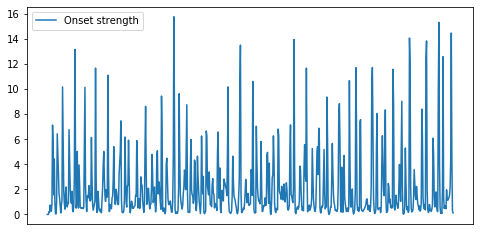

In [33]:
plt.figure(figsize=(8, 4))

# Plot Onset Envelope
#plt.subplot(4, 1, 1)
plt.plot(oenv, label='Onset strength')
plt.xticks([])
plt.legend(frameon=True)
plt.axis('tight')

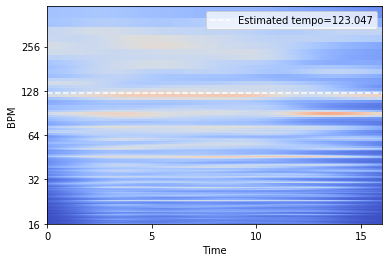

In [34]:
# Plot Tempogram
#plt.subplot(4, 1, 2)
# We'll truncate the display to a narrower range of tempi
librosa.display.specshow(tempogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='tempo')
plt.axhline(tempo, color='w', linestyle='--', alpha=1, label='Estimated tempo={:g}'.format(tempo))
plt.legend(frameon=True, framealpha=0.75)

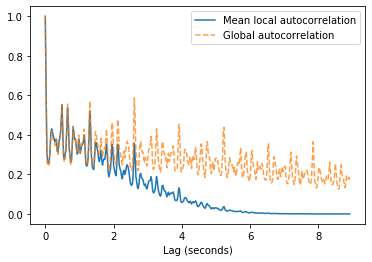

In [35]:
# Plot Autocorrelations (time scale)
#plt.subplot(4, 1, 3)
x = np.linspace(0, tempogram.shape[0] * float(hop_length) / sr, num=tempogram.shape[0])
plt.plot(x, np.mean(tempogram, axis=1), label='Mean local autocorrelation')
plt.plot(x, ac_global, '--', alpha=0.75, label='Global autocorrelation')
plt.xlabel('Lag (seconds)')
plt.axis('tight')
plt.legend(frameon=True)

I bet I'd be able to see a zouk beat in this plot.

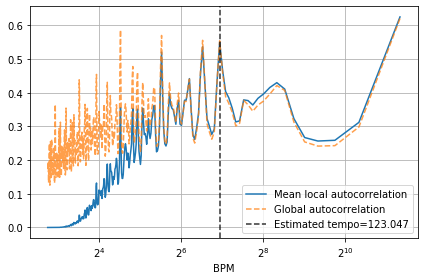

In [36]:
# Plot Autocorrelations (bpm scale)
#plt.subplot(4,1,4)
# We can also plot on a BPM axis
freqs = librosa.tempo_frequencies(tempogram.shape[0], hop_length=hop_length, sr=sr)
plt.semilogx(freqs[1:], np.mean(tempogram[1:], axis=1), label='Mean local autocorrelation', basex=2)
plt.semilogx(freqs[1:], ac_global[1:], '--', alpha=0.75, label='Global autocorrelation', basex=2)
plt.axvline(tempo, color='black', linestyle='--', alpha=.8, label='Estimated tempo={:g}'.format(tempo))
plt.legend(frameon=True)
plt.xlabel('BPM')
plt.axis('tight')
plt.grid()
plt.tight_layout()
plt.show()

# Feature Dimensions

What are the sizes of the arrays we are creating, and what does each dimension represent?

Librosa documentation shows how to use the functions, but there's not much detail about what these features mean. I'll have to look up some papers, or refer to the Audio Analysis book.

## Spectrogram

In [37]:
print("Spectrogram shape:", S.shape)
print("Spectrogram_db shape:", S_dB.shape)

Spectrogram shape: (128, 690)
Spectrogram_db shape: (128, 690)


## MFCC

In [38]:
print("MFCCs shape:", mfccs.shape)

MFCCs shape: (40, 690)


## Tempogram

In [39]:
print("Onset Envelope shape:", oenv.shape)
print("Tempogram shape:", tempogram.shape)
print("Autocorrelations shape:", ac_global.shape)

Onset Envelope shape: (690,)
Tempogram shape: (384, 690)
Autocorrelations shape: (384,)


# Cosine Similarity of Audio Files

In [40]:
from sklearn.metrics.pairwise import cosine_similarity

song1 = "data/raw/mp3s/003YJwKQXHZ3OcQZO72tHA.mp3"
song2 = "data/raw/mp3s/00kWGi3KI7xqeVpC6Kkaqt.mp3"

y1, sr1 = librosa.load(song1)
y2, sr2 = librosa.load(song2)

mfccs1 = librosa.feature.mfcc(y=y1, sr=sr1, n_mfcc=12)
mfccs2 = librosa.feature.mfcc(y=y2, sr=sr2, n_mfcc=12)

r, c = mfccs1.shape
cosine_similarity(mfccs1.reshape((1,r*c)), mfccs2.reshape((1,r*c)))